<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/ACF/ACF_and_SARIMAX_for_differenced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

<Axes: xlabel='DT'>

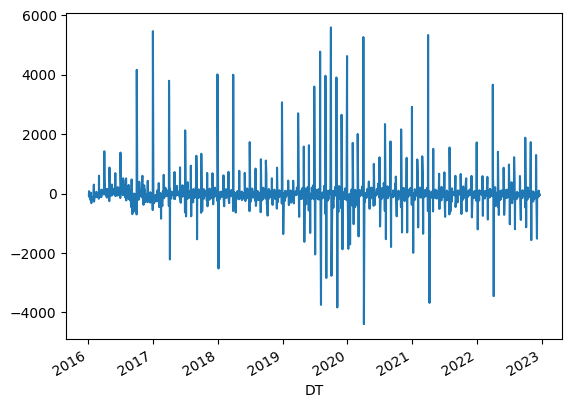

In [ ]:
df_copy = df
df_copy['ANTAL_01'] = df_copy['ANTAL_01'].astype(float) - df_copy['ANTAL_01'].astype(float).shift(1)
df_copy['ANTAL_01'].dropna().plot()

In [ ]:
df_copy.dropna()

,ANTAL_01
DT,
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0
2016-01-08,-35.0
...,...
2022-12-15,101.0
2022-12-16,-67.0
2022-12-19,-61.0


In [ ]:
#training and test
training = df_copy.iloc[:-16,:]
print(training.index)
testing = df_copy.iloc[-16:, :]
training.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2015-12-31,NaN
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0


In [ ]:
# calculate ACF on the whole dataset
acf = sm.tsa.acf(training.dropna(), nlags=len(training)-1)

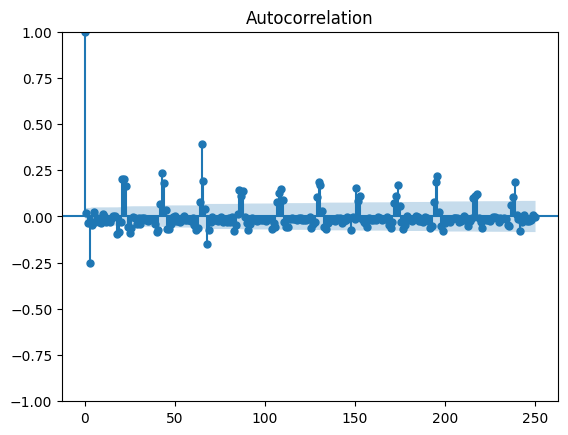

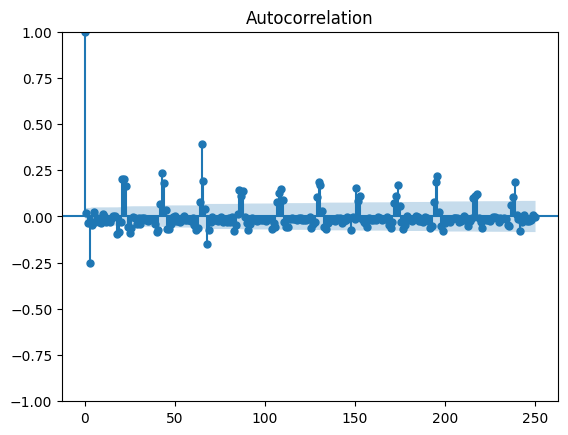

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(training.dropna(), lags = 250) 

In [ ]:
training = training.dropna()
testing = testing.dropna()
# repeat the ACF values until it matches the length of the training dataset
acf_repeated = np.tile(acf, int(np.ceil(len(training) / len(acf))))[:len(training)]

In [ ]:
# create a DataFrame with the repeated ACF values as a column
exog = pd.DataFrame({'acf': acf}, index=training.index)

In [ ]:
# drop any rows with missing values from the exog dataframe
exog = exog.dropna()

In [ ]:
np.asarray(training)

array([[ -58.],
       [  82.],
       [-113.],
       ...,
       [  29.],
       [ -14.],
       [-148.]])

In [ ]:
# fit SARIMAX model with exogenous variable
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=np.asarray(exog), order=(3,0,3), seasonal_order=(3,0,3,22))
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
exogTest = exog.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2['acf'])
exogvar = np.asarray(exogTest2['acf'])
# make predictions with the fitted model and exogenous variables for test dataset
test_exog = pd.DataFrame({'acf': exogvar}, index=testing.index)
test_exog

,acf
DT,
2022-11-30,0.000457
2022-12-01,0.000234
2022-12-02,0.000152
2022-12-05,0.000366
2022-12-06,0.000143
2022-12-07,0.000317
2022-12-08,0.000100
2022-12-09,0.000176
2022-12-12,0.000201


In [ ]:
# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


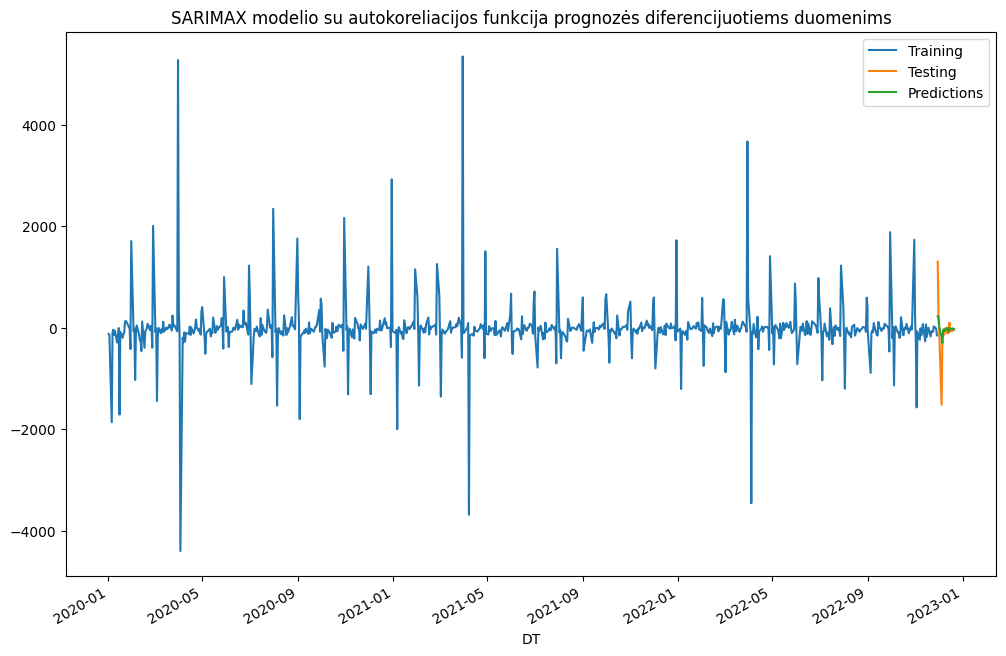

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su autokoreliacijos funkcija prognozės diferencijuotiems duomenims')
plt.legend()

In [ ]:
pred, testing['ANTAL_01']

(DT
 2022-11-30    231.286844
 2022-12-01    191.136716
 2022-12-02     15.570980
 2022-12-05   -186.518567
 2022-12-06   -304.016951
 2022-12-07    -43.073947
 2022-12-08    -28.300944
 2022-12-09    -59.547813
 2022-12-12      5.440700
 2022-12-13    -33.071275
 2022-12-14    -73.296459
 2022-12-15     -5.660772
 2022-12-16    -31.198358
 2022-12-19     -9.387556
 2022-12-20    -19.388851
 2022-12-21    -32.080490
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30    1301.0
 2022-12-01     317.0
 2022-12-02    -106.0
 2022-12-05   -1516.0
 2022-12-06    -159.0
 2022-12-07    -153.0
 2022-12-08    -135.0
 2022-12-09     -11.0
 2022-12-12    -105.0
 2022-12-13     -62.0
 2022-12-14     -98.0
 2022-12-15     101.0
 2022-12-16     -67.0
 2022-12-19     -61.0
 2022-12-20     -31.0
 2022-12-21     -31.0
 Name: ANTAL_01, dtype: float64)

In [ ]:
predictions = pred

In [ ]:
last_values = df.iloc[:-16,:]
last_value = last_values[-1:]
last_value
original_preds= []
for pred in predictions:
    pred_value = last_value + pred
    original_preds.append(pred_value)
    last_value = pred_value
print(original_preds)

[                ANTAL_01
DT                      
2022-11-29  31137.286844,                 ANTAL_01
DT                      
2022-11-29  31328.423561,                ANTAL_01
DT                     
2022-11-29  31343.99454,                 ANTAL_01
DT                      
2022-11-29  31157.475973,                 ANTAL_01
DT                      
2022-11-29  30853.459022,                 ANTAL_01
DT                      
2022-11-29  30810.385075,                 ANTAL_01
DT                      
2022-11-29  30782.084131,                 ANTAL_01
DT                      
2022-11-29  30722.536319,                 ANTAL_01
DT                      
2022-11-29  30727.977019,                 ANTAL_01
DT                      
2022-11-29  30694.905744,                 ANTAL_01
DT                      
2022-11-29  30621.609286,                 ANTAL_01
DT                      
2022-11-29  30615.948513,                 ANTAL_01
DT                      
2022-11-29  30584.750156,               